# EasyVVUQ - Vector Quantities of Interest

**Author**: Vytautas Jancauskas, LRZ (jancauskas@lrz.de)

It is often the case that simulation outputs are vector valued and represent changes over time in whatever phenomenon that is simulated. Here we examine how to analyse these cases with EasyVVUQ. As an example we use the following model from epidemiology - [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model). It compartmentalises the population into the following groups: ($S$)usceptible, ($I$)nfected and ($R$)emoved. There are four input parameters to out model. They are initial number of susceptible people $S_0$, initial number of infected people $I_0$, transmission rate $\beta$ and recovery rate $\gamma$. The system is governed by three differential equations below. The number of suspectible people is reduced by them getting infected (and thus moving to $I$) at rate specified by $\beta$. The number of infected people increases similarly. Finally the number of recovered people increases depending on the recovery rate and the number of people currently infected.

$${\frac  {dS}{dt}}=-{\frac  {\beta SI}{N}}$$

$${\displaystyle {\frac {dI}{dt}}={\frac {\beta SI}{N}}-\gamma I}$$

$${\displaystyle {\frac {dR}{dt}}=\gamma I}$$

The simulation is run as shown below, where ```input_file``` is a JSON file of the following format: ```{"outfile": "$outfile", "S0": $S0, "I0": $I0, "beta": $beta, "gamma": $gamma, "iterations": $iterations}```

```sir <input_file>```

Lets try and run it.

In [ ]:
!echo "{\"outfile\": \"output.csv\", \"S0\": 997, \"I0\": 3, \"beta\": 0.2, \"gamma\": 0.04, \"iterations\": 100}" > input.json

In [ ]:
!./sir input.json

The simulation code outputs a CSV file with a specified name. We can try opening it up and printing the first 10 lines.

In [ ]:
!head output.csv

Finally lets plot the results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('output.csv')

As we can see it shows the number of infected people increasing at first and then decreasing as the number of people who have recovered rises. Number of susceptible and recovered people also changes in a way that makes intuitive sense.

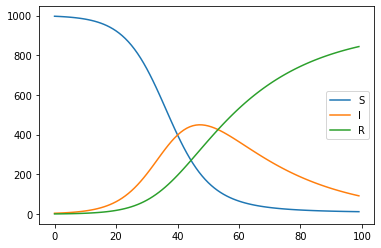

In [2]:
plt.plot(df['S'], label='S')
plt.plot(df['I'], label='I')
plt.plot(df['R'], label='R')
plt.legend()

So let us see what EasyVVUQ can tell us about the distribution of the number of infected people over time. We will not go into the details of the EasyVVUQ API this time. Only where it differs from the [basic concepts](./basic_tutorial.ipynb) tutorial.

In [3]:
import easyvvuq as uq
import chaospy as cp
import os
import matplotlib.pyplot as plt

In [4]:
params = {
    "S0": {"type": "float", "default": 997}, 
    "I0": {"type": "float", "default": 3}, 
    "beta": {"type": "float", "default": 0.2}, 
    "gamma": {"type": "float", "default": 0.04, "min": 0.0, "max": 1.0},
    "iterations": {"type": "integer", "default": 100},
    "outfile": {"type": "string", "default": "output.csv"}
}

Encoder is the same as in the basic concepts tutorial, essentially. However, since the simulation outputs a CSV file with the evolution of output variables over time we want the ```SimpleCSV``` decoder. The arguments to it should be self explanatory.

In [5]:
encoder = uq.encoders.GenericEncoder(template_fname='sir.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', output_columns=['I'])
actions = uq.actions.local_execute(encoder, os.path.abspath('sir') + ' input.json', decoder)

In [6]:
campaign = uq.Campaign(name='sir', params=params, actions=actions)

We assume that the infection rate $\beta$ is uniformly distributed between 0.15 and 0.25 and the recovery rate $\gamma$ is normally distributed with mean 0.04 and small variance.

In [7]:
vary = {
    "beta": cp.Uniform(0.15, 0.25),
    "gamma": cp.Normal(0.04, 0.01),
}

For this tutorial we will use Polynomial Chaos Expansion method. However, both [SCSampler](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.stochastic_collocation) and [QMCSampler](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.qmc) would work as well and might be preferable depending on the case.

In [8]:
campaign.set_sampler(uq.sampling.PCESampler(vary=vary, polynomial_order=5))

In [9]:
execution = campaign.execute()

In [19]:
execution.progress()

{'ready': 0, 'active': 0, 'finished': 36, 'failed': 0}

In [20]:
execution.collate()
result = campaign.analyse(qoi_cols=['I'])

We can now see the results of the analysis. One thing to try would be to plot the first order sobol indices over time. This shows us how much influence the two parameters (```beta``` and ```gamma```) have over the number of people infected over time ```t```. The ```higher orders``` line is meant to represent the influence of the interactions between the input variables. However it is negligible in this case.

<AxesSubplot:xlabel='t', ylabel='First Order Sobol Index'>

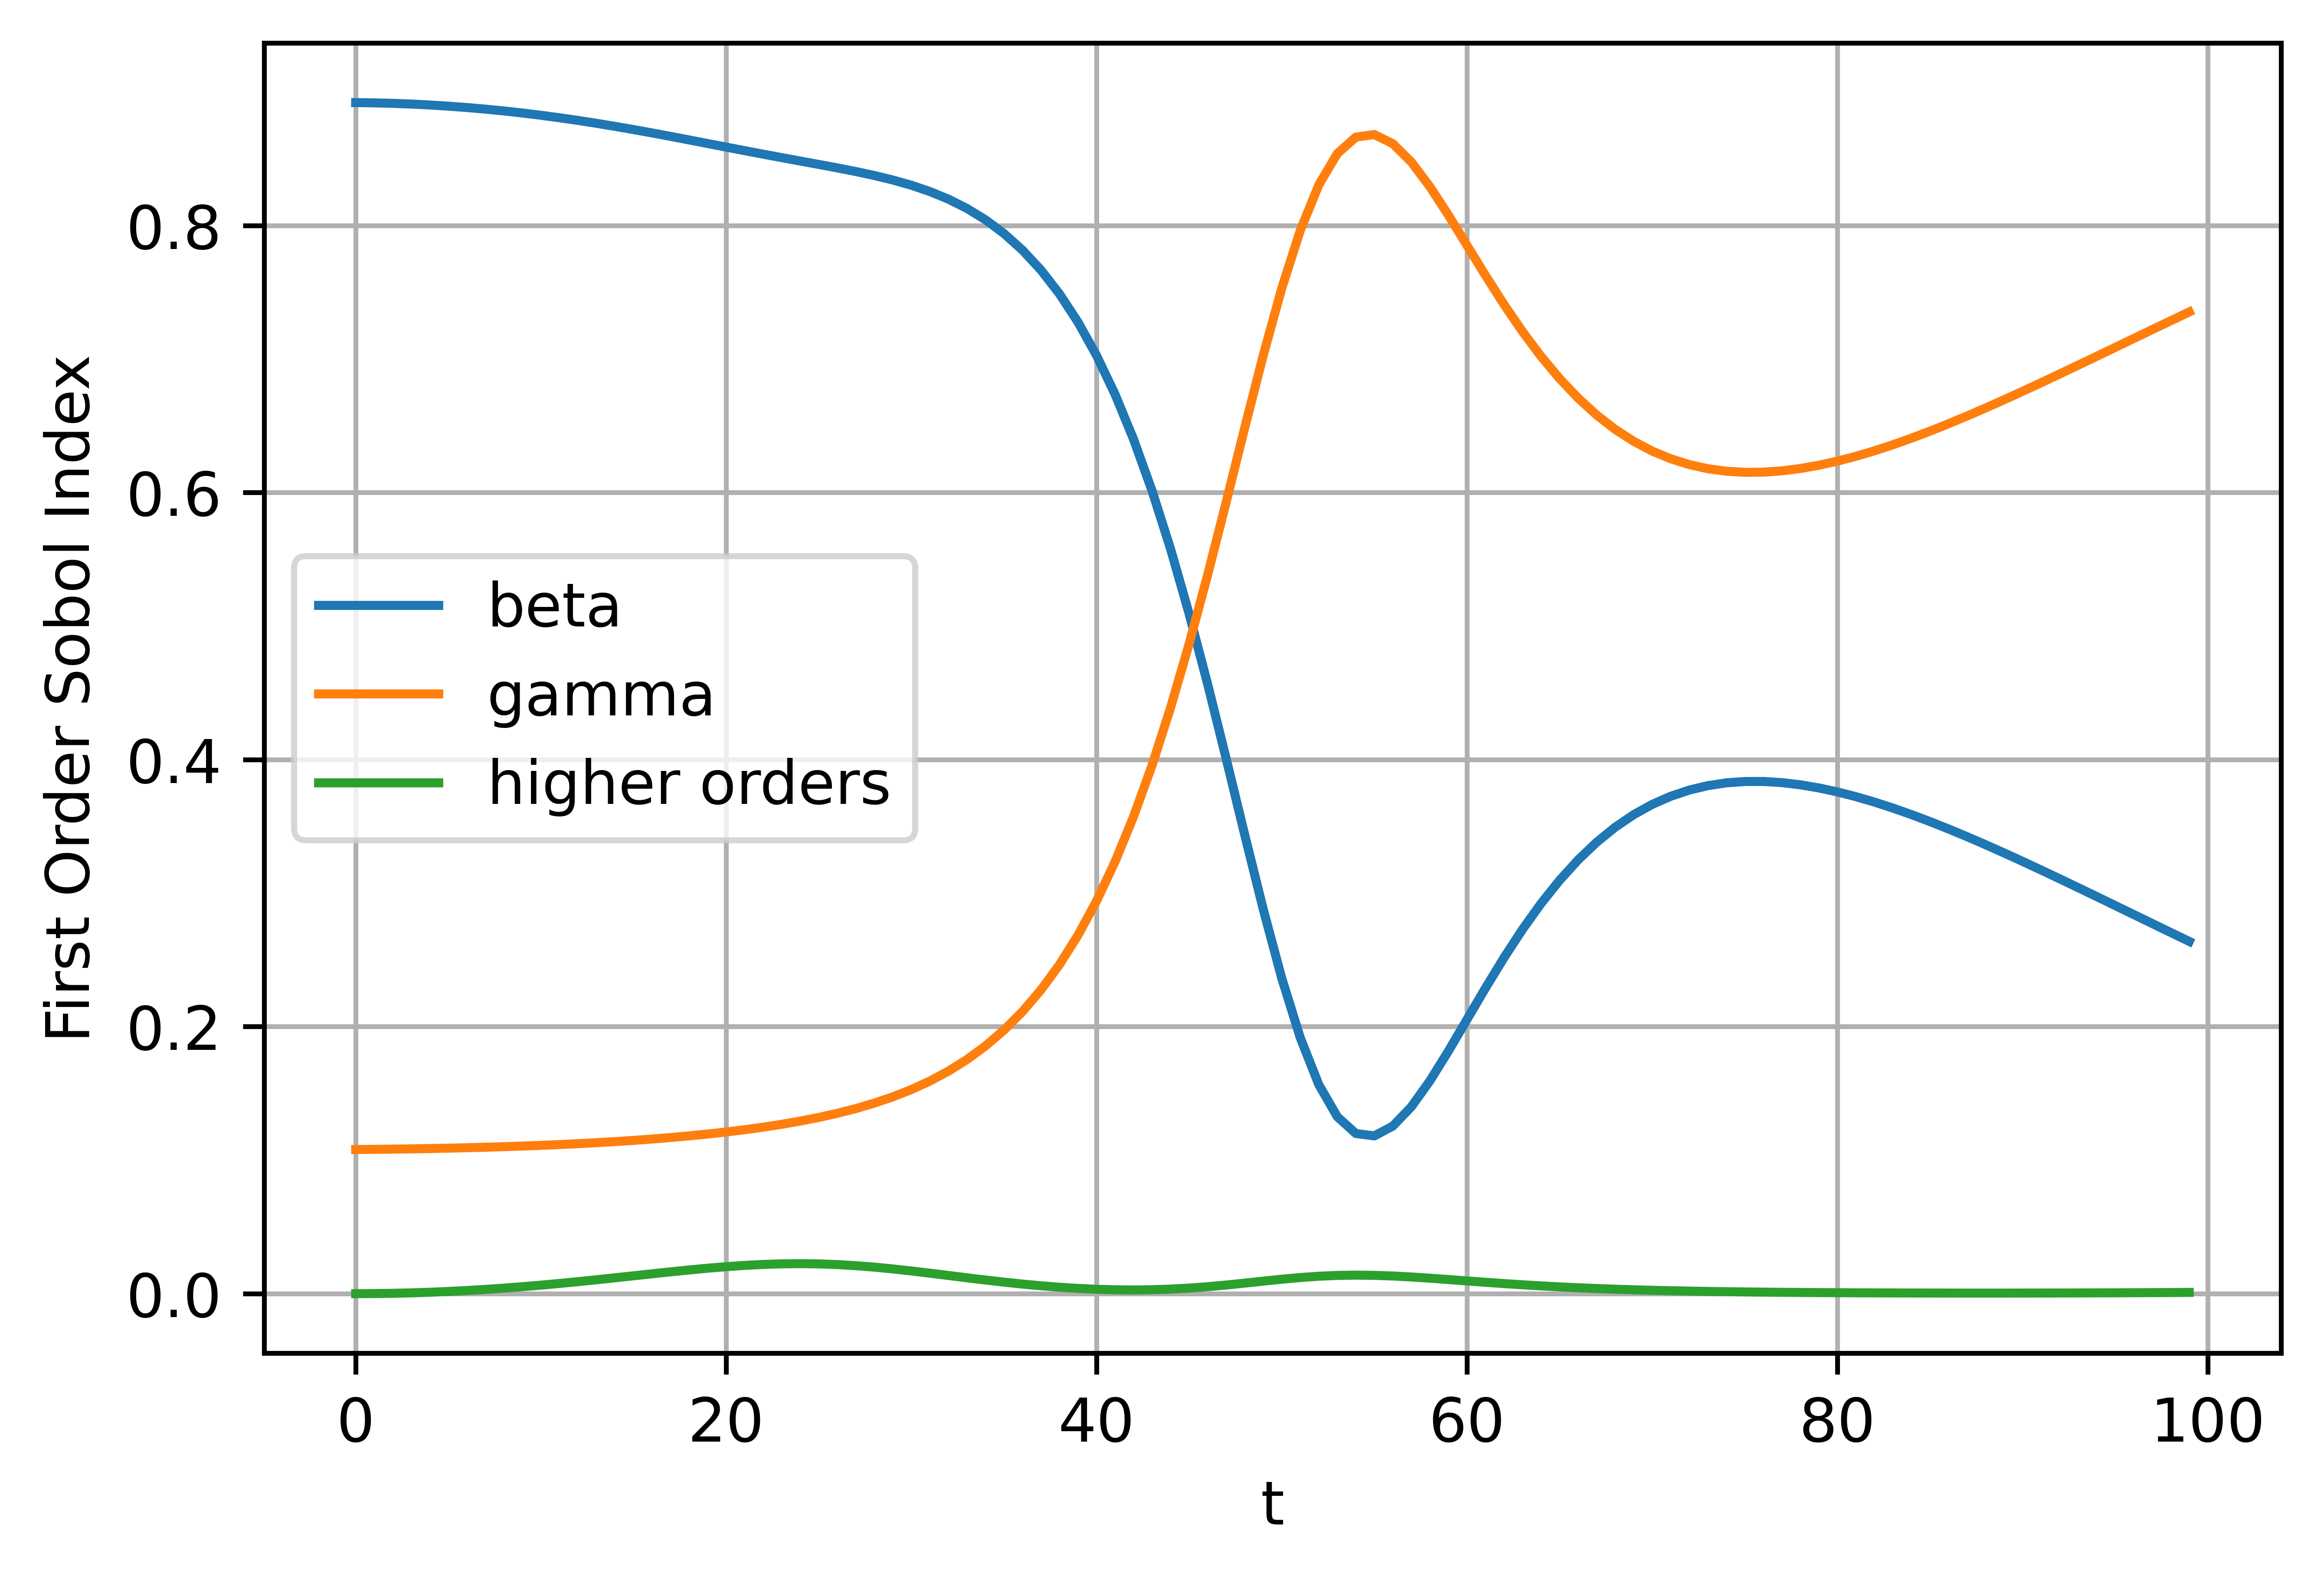

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1000
result.plot_sobols_first('I', xlabel='t')

Finally we can try and visualize certain aspects of the distribution for our quantity of interest (number of infected people) over time. In this plot we will plot the mean value, standard deviation and 0.01 and 0.99 quantiles. This is with respect to the input variable distributions we have specified in the ```vary``` dictionary.

<AxesSubplot:xlabel='t', ylabel='I'>

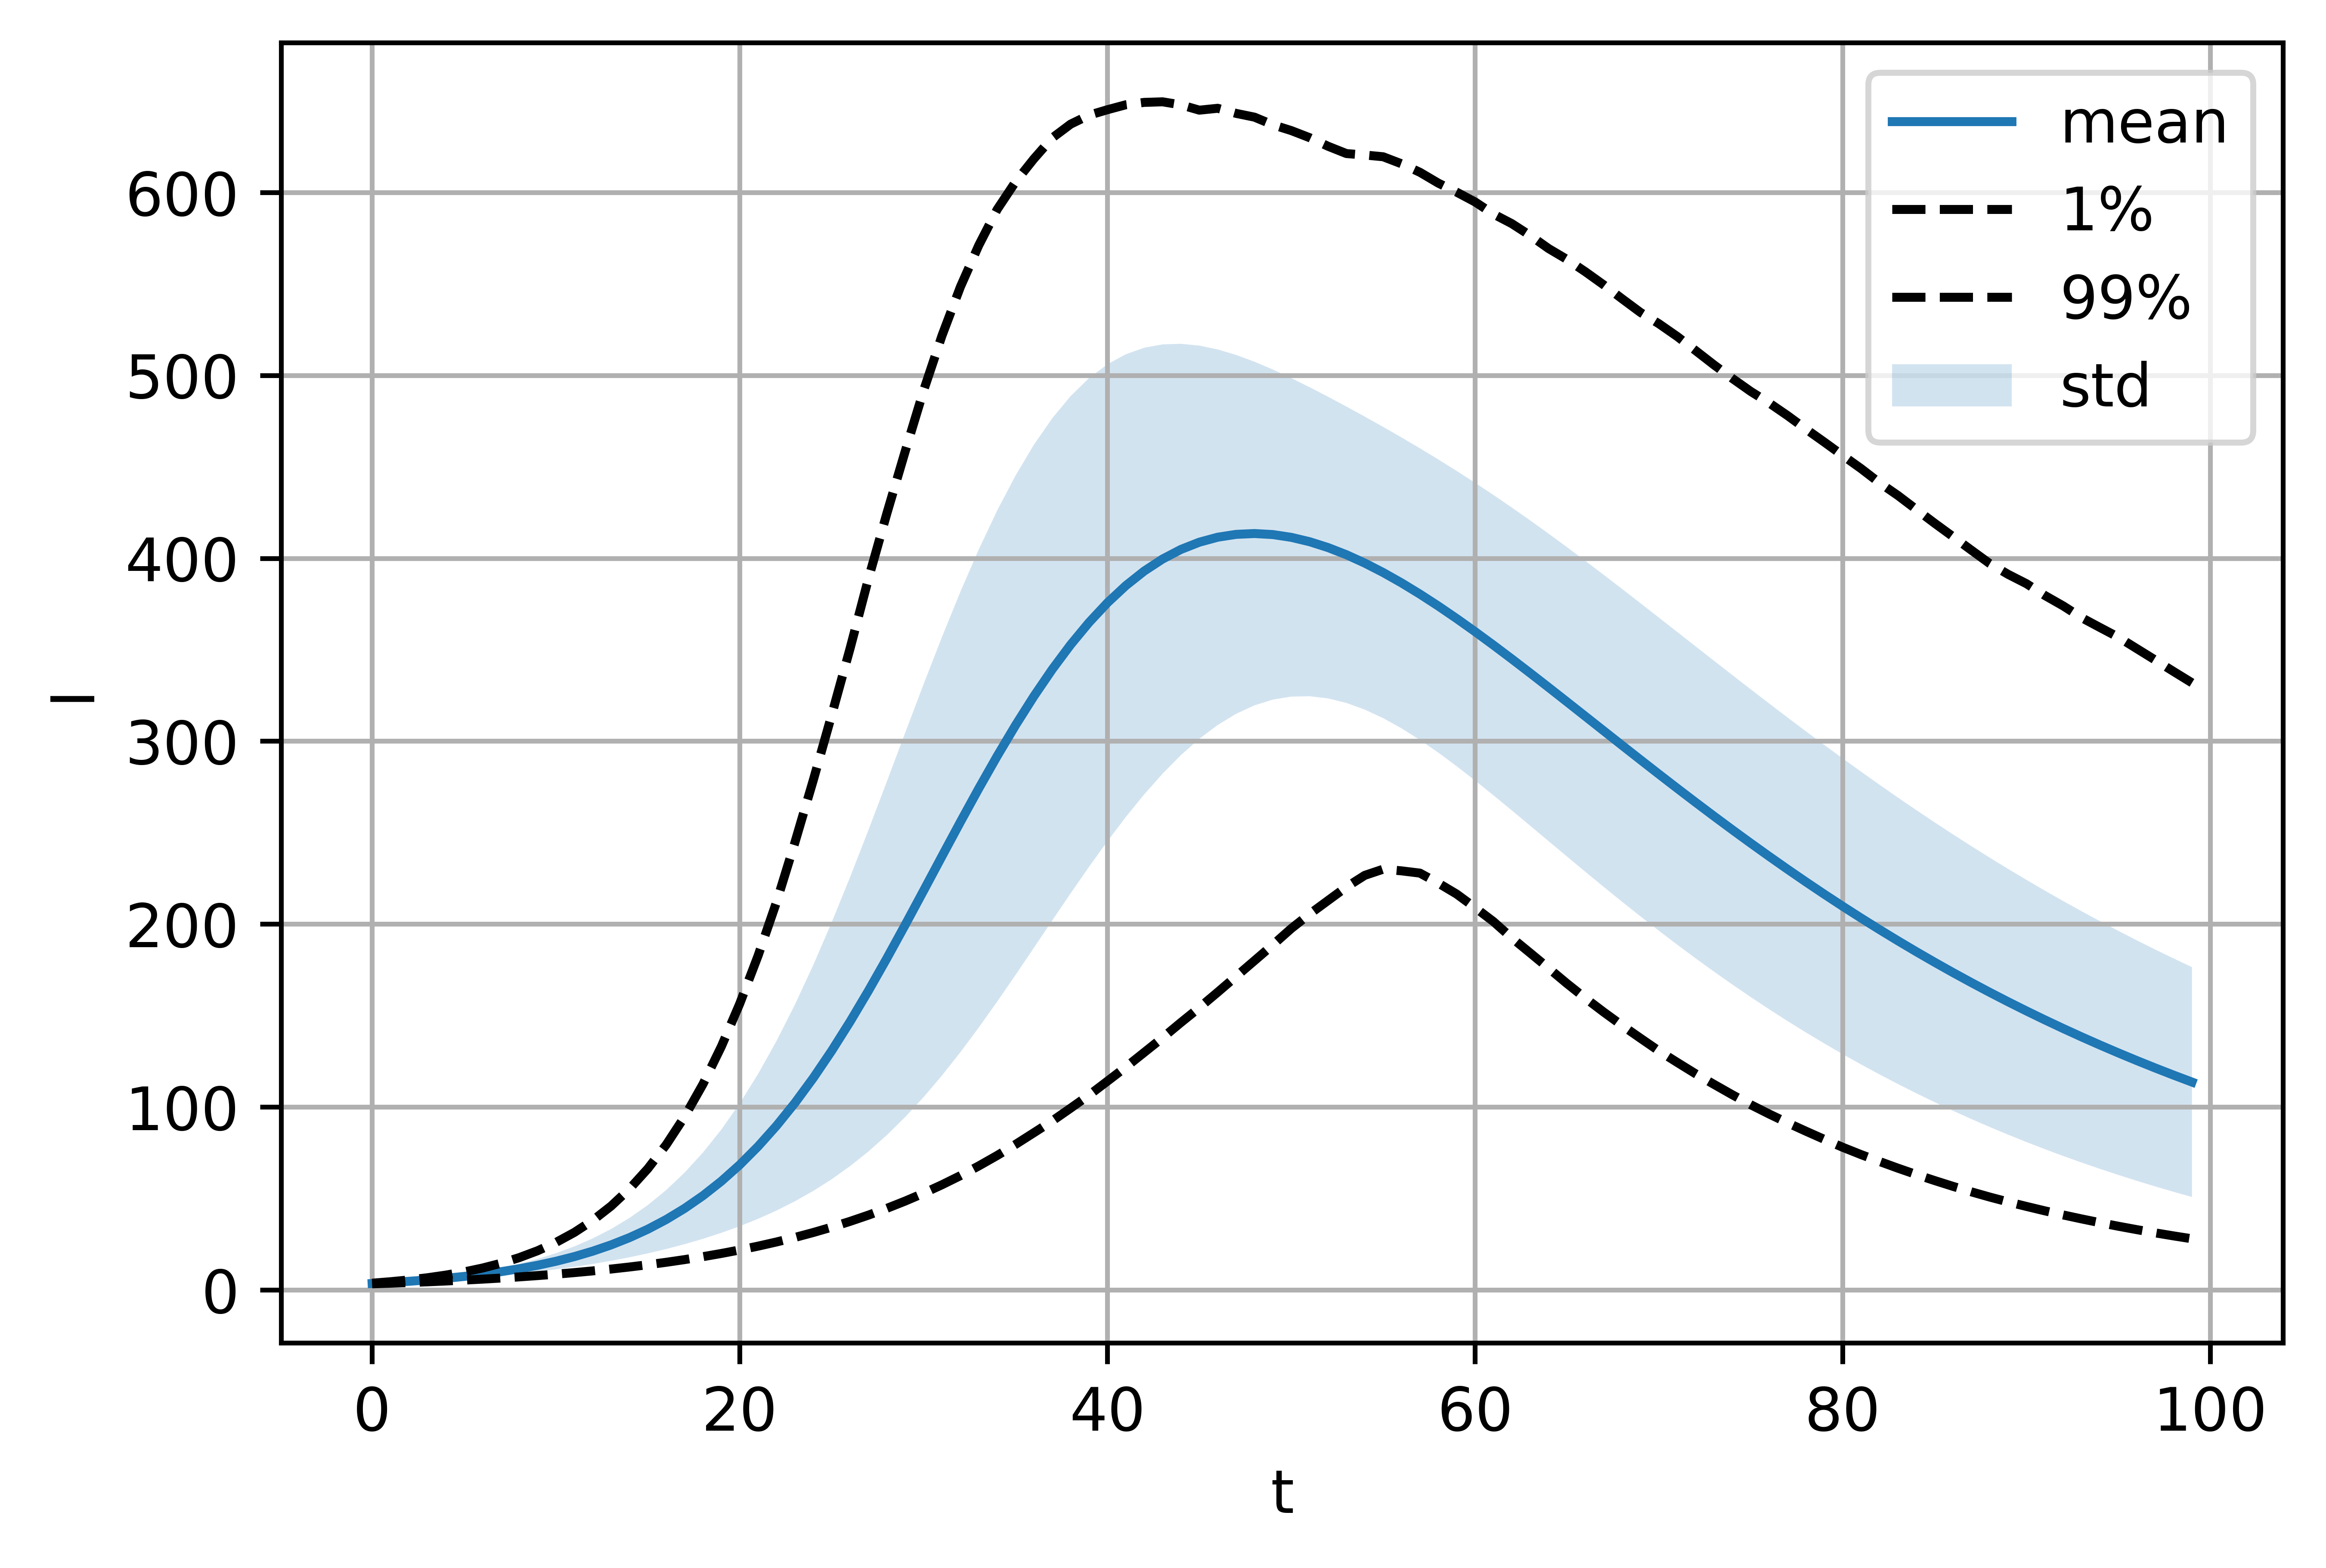

In [26]:
result.plot_moments('I', xlabel='t')

If you want to access all of this data for processing you can use the following methods. Due to large output I have not evaluated these cells.

In [27]:
result.sobols_first('I')

{'beta': array([0.89204991, 0.89185266, 0.89149001, 0.89096097, 0.89026466,
        0.88940042, 0.88836788, 0.88716713, 0.88579887, 0.88426465,
        0.88256715, 0.88071051, 0.87870074, 0.87654612, 0.87425765,
        0.87184944, 0.86933898, 0.86674715, 0.86409788, 0.8614171 ,
        0.85873111, 0.85606382, 0.85343316, 0.85084649, 0.84829549,
        0.84575091, 0.84315795, 0.84043276, 0.83746062, 0.83409584,
        0.83016322, 0.82546019, 0.81975914, 0.81280885, 0.80433458,
        0.7940368 , 0.78158862, 0.76663314, 0.74878204, 0.72761773,
        0.7027023 , 0.67359755, 0.63990145, 0.60130728, 0.55769073,
        0.50922621, 0.45652411, 0.40076392, 0.34377714, 0.28801728,
        0.23636068, 0.19172748, 0.15659244, 0.13253095, 0.11995903,
        0.11815331, 0.12551813, 0.13997798, 0.15935905, 0.18167041,
        0.20525921, 0.22885867, 0.25156611, 0.272786  , 0.29216284,
        0.30951812, 0.32479749, 0.33802971, 0.34929615, 0.35870914,
        0.366397  , 0.37249406, 0.377134

In [29]:
result.describe('I', 'mean')

array([  3.4778336 ,   4.03404206,   4.68171534,   5.43612205,
         6.31505352,   7.3392123 ,   8.5326462 ,   9.92322633,
        11.54316403,  13.42955585,  15.62493745,  18.17781631,
        21.14313804,  24.58262204,  28.56487862,  33.16519322,
        38.46483541,  44.54972656,  51.50828773,  59.42829956,
        68.39265292,  78.47396641,  89.72820311, 102.18763148,
       115.85371859, 130.69076976, 146.62126765, 163.52384337,
       181.23458606, 199.55197143, 218.24513987, 237.06470706,
       255.75488712, 274.06555177, 291.76296652, 308.63828094,
       324.51329838, 339.24349061, 352.71856713, 364.86111453,
       375.62389166, 384.98633302, 392.95071792, 399.53834415,
       404.78592878, 408.74236162, 411.46586385, 413.02155449,
       413.47939812, 412.91249216, 411.39564756, 409.00421782,
       405.81313627, 401.89612761, 397.32506563, 392.16945484,
       386.49601832, 380.36837781, 373.84681454, 366.98810159,
       359.84539945, 352.46820727, 344.90236319, 337.19

In [ ]:
result.describe('I', 'std')

In [ ]:
result.describe('I', '1%')

In [ ]:
result.describe('I', '99%')